In [1]:
import warnings
warnings.simplefilter('ignore')
import nussl
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import shutil
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import json # to print dictionary
from glob import glob
from pathlib import Path

from importlib import reload 
import nussl_fram
reload (nussl_fram)
from nussl_fram import dataset_v3
from collections import defaultdict

import time

if torch.cuda.is_available():
    print('yes')
    device='cuda'
else:
    device='cpu'

OUTPUT_FOLDER = os.path.join(os.getcwd(), 'output')
ESTIMATES_DIR = os.path.join(OUTPUT_FOLDER, "estimates")
# shutil.rmtree(ESTIMATES_DIR) # ! Delete previous estimates
RESULTS_DIR = os.path.join(OUTPUT_FOLDER, 'results')
MODEL_PATH = os.path.join(OUTPUT_FOLDER, 'checkpoints/best.model.pth')
PATH = os.path.join(os.getcwd(), "audio")
NUM_WORKERS = 8

state = 'msa' # == phase # Optional to be msa ==  Magnitud
SR = 44100

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


Device is cpu
Device is cpu


In [2]:
start_time = time.time()

In [3]:
def visualize_and_embed(sources, title, y_axis='mel'):
    plt.figure(figsize=(10, 4))
    plt.subplot(111)
    plt.title(title)
    nussl.utils.visualize_sources_as_masks(
        sources, db_cutoff=-60, y_axis=y_axis)
    plt.tight_layout()
    plt.show()

    plt.subplot(212)
    #nussl.utils.visualize_sources_as_waveform(sources, show_legend=False)
    #librosa -> amplitude (sources)
    plt.tight_layout()
    plt.show()

    for source in sources:
        source.peak_normalize()
        source.embed_audio()
    # nussl.play_utils.multitrack(sources, ext='.wav')

In [4]:
database = dataset_v3(PATH, sample_rate = SR)
print(f"There are {len(database)} samples in the data")

There are 125 samples in the data


## Demo

In [5]:
item = database[9]  # <-- This is an AugioSignal obj

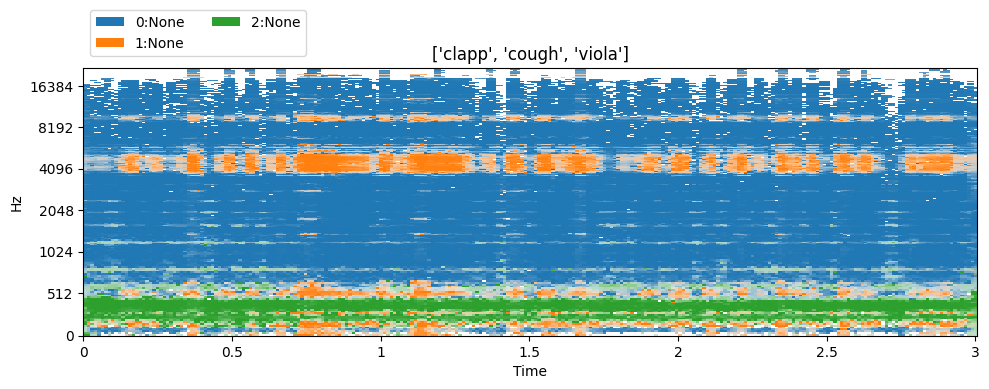

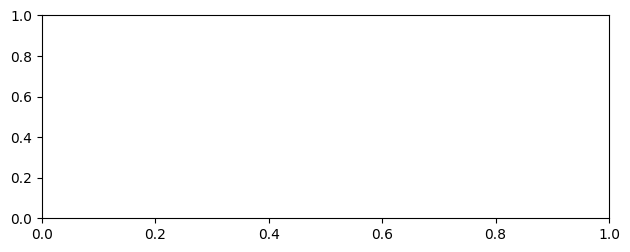

In [6]:
def forward_on_device(audio_signal):
    dme = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path = MODEL_PATH, device = device)
    # set the audio signal of the object to this item's mix
    dme.audio_signal = audio_signal
    masks = dme.forward()
    return masks


item['mix'].embed_audio()
masks = forward_on_device(item['mix'])
separator = nussl.separation.deep.DeepMaskEstimation(item['mix'])
estimates = separator(masks)
visualize_and_embed(estimates, item['metadata']['lables'])

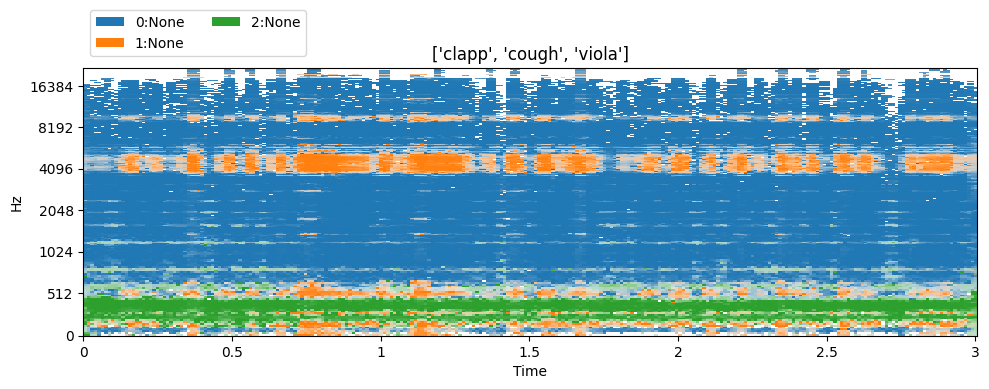

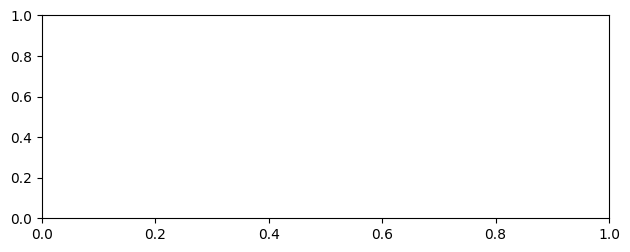

In [7]:
separator = nussl.separation.deep.DeepMaskEstimation(
    item['mix'], model_path=MODEL_PATH)

item['mix'].embed_audio()
estimates = separator()
# estimates = {
#     source_names[i]: e for i, e in enumerate(estimates)
# }
visualize_and_embed(estimates, item['metadata']['lables'])

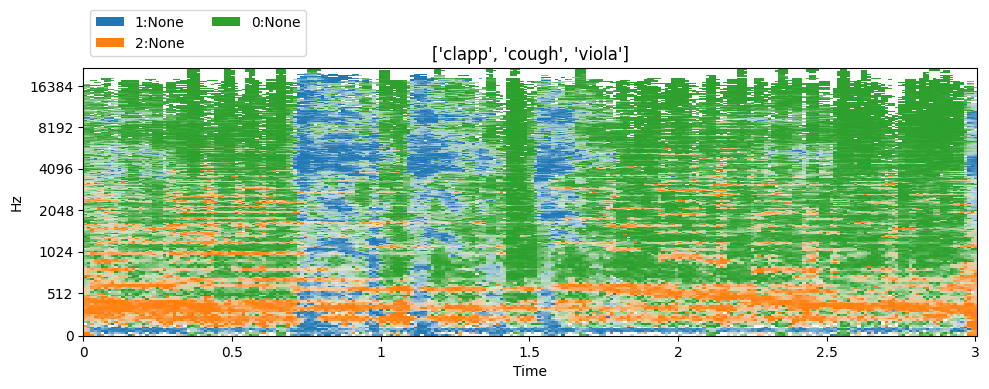

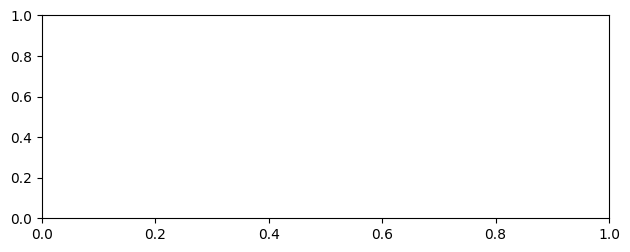

In [8]:
# Ideal Binary Mask - Magnitude spectrum approximation
ground_truth_separator = nussl.separation.benchmark.IdealRatioMask(
    item['mix'], item['sources'])
ground_truth_estimates = ground_truth_separator()
item['mix'].embed_audio()
visualize_and_embed(ground_truth_estimates, item['metadata']['lables'])

Wiener, Norbert. Extrapolation, interpolation, and smoothing of stationary time series. 
The MIT press, 1964.

    Uhlich and M. Porcu and F. Giron and M. Enenkl and T. Kemp and N. Takahashi and Y. Mitsufuji, “Improving music source separation based on deep neural networks through data augmentation and network blending.” 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2017.

    Nugraha and A. Liutkus and E. Vincent. “Multichannel audio source separation with deep neural networks.” IEEE/ACM Transactions on Audio, Speech, and Language Processing 24.9 (2016): 1652-1664.

    Nugraha and A. Liutkus and E. Vincent. “Multichannel music separation with deep neural networks.” 2016 24th European Signal Processing Conference (EUSIPCO). IEEE, 2016.

    Liutkus and R. Badeau and G. Richard “Kernel additive models for source separation.” IEEE Transactions on Signal Processing 62.16 (2014): 4298-4310.


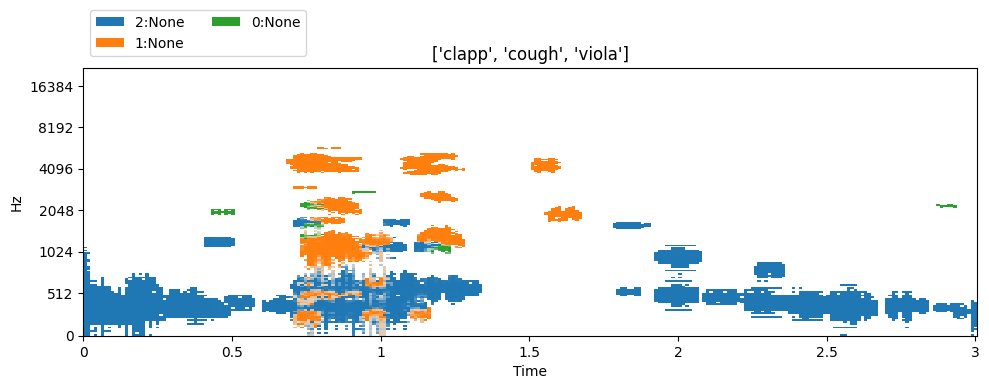

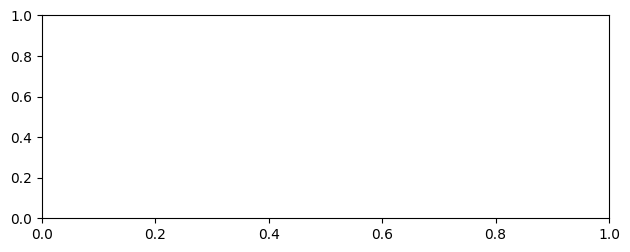

In [9]:
# Wiener Filter Mask - Magnitude spectrum approximation
wiener_seperetor  = nussl.separation.benchmark.WienerFilter(
    item['mix'], list(item['sources'].values()), iterations=10)
wiener_estimates = wiener_seperetor()
item['mix'].embed_audio()
visualize_and_embed(wiener_estimates, item['metadata']['lables'])

## Evaluation
    Original BSS Evaluation metrics:

New BSS Evaluation metrics: these metrics are refined versions of the originals and are argued to be more robust.

Precision and recall on binary masks: an older way to evaluate methods is to look at the values of the actual mask and the estimated mask and compute precision/recall over each time-frequency bin.

An estimate of a Source $\hat{s_i}$

is assumed to actually be composed of four separate components

$\hat{s_i} = s_{target}+e_{interf}+e_{noise}+e_{artif} $

$s_{target}$ is the true source

$e_{interf}$, $e_{noise}$, and $e_{artif}$ are error terms for interference, noise and artif, respectively. 

Using these four terms, we can define our measures. All of the measures are in terms of decibels (dB), with higher values being better. To calculate they require access to the ground truth isolated sources and are usually calculated on a signal that has been divided into short windows of a few seconds long.

https://arxiv.org/pdf/1607.08022.pdf
https://inria.hal.science/inria-00544230/document 

In [10]:
print(item['metadata']['lables'], '\n')

for signal in estimates:
    print(signal)
    print("Duration: {} seconds".format(signal.signal_duration))
    print("Duration in samples: {} samples".format(signal.signal_length))
    print("Number of channels: {} channels".format(signal.num_channels))
    print("File name: {}".format(signal.file_name))
    print("Full path to input: {}".format(signal.path_to_input_file))
    print("Root mean square energy: {:.4f}".format(signal.rms().mean()))
    print('\n')

['clapp', 'cough', 'viola'] 

AudioSignal (unlabeled): 3.000 sec @ path unknown, 44100 Hz, 1 ch.
Duration: 3.0 seconds
Duration in samples: 132300 samples
Number of channels: 1 channels
File name: None
Full path to input: None
Root mean square energy: 0.0933


AudioSignal (unlabeled): 3.000 sec @ path unknown, 44100 Hz, 1 ch.
Duration: 3.0 seconds
Duration in samples: 132300 samples
Number of channels: 1 channels
File name: None
Full path to input: None
Root mean square energy: 0.0757


AudioSignal (unlabeled): 3.000 sec @ path unknown, 44100 Hz, 1 ch.
Duration: 3.0 seconds
Duration in samples: 132300 samples
Number of channels: 1 channels
File name: None
Full path to input: None
Root mean square energy: 0.1663




$e_{interf}$, $e_{noise}$ and $e_{artif} $

e_interf = Ps.dot(original_chunk) - Ps.dot(estimated_chunk)

e_noise = Ps_n.dot(original_chunk) - Ps.dot(original_chunk)

e_artif = original_chunk - Ps_n.dot(original_chunk)

In [11]:
def calculate_error(original_signal, estimated_signal, chunk_size= 2000):
    assert len(original_signal) == len(estimated_signal)
    # Calculate the length of the signals
    signal_length = len(original_signal)

    # Initialize error terms
    e_interf = np.zeros(signal_length)
    e_noise = np.zeros(signal_length)
    e_artif = np.zeros(signal_length)

    # Process the signals in smaller chunks
    for i in range(0, signal_length, chunk_size):
        chunk_end = min(i + chunk_size, signal_length)

        # Calculate the chunk of original signal
        original_chunk = original_signal[i:chunk_end]

        # Calculate the chunk of estimated signal
        estimated_chunk = estimated_signal[i:chunk_end]

        # Calculate the orthogonal projector for the estimated signal
        Ps = np.outer(estimated_chunk, estimated_chunk) / np.linalg.norm(estimated_chunk)**2

        # Calculate the orthogonal projector for the estimated signal and the noise subspace
        Ps_n = Ps 
        if np.linalg.norm(original_chunk) != 0:
            Ps_n = Ps - np.outer(original_chunk, original_chunk) / np.linalg.norm(original_chunk)**2
            

        # Calculate the interference error for the chunk
        e_interf_chunk = Ps.dot(original_chunk) - Ps.dot(estimated_chunk)
        e_interf[i:chunk_end] = e_interf_chunk

        # Calculate the noise error for the chunk
        e_noise_chunk = Ps_n.dot(original_chunk) - Ps.dot(original_chunk)
        e_noise[i:chunk_end] = e_noise_chunk

        # Calculate the artifact error for the chunk
        e_artif_chunk = original_chunk - Ps_n.dot(original_chunk)
        e_artif[i:chunk_end] = e_artif_chunk

    # # # Debug mode:
    # original_signal = np.array([1, 2, 3, 4, 5])
    # estimated_signal = np.array([0.8, 1.9, 2.7, 4.2, 5.3])
    # chunk_size = 3

    # e_interf, e_noise, e_artif = calculate_error_terms(original_signal, estimated_signal, chunk_size)

    # print("Interference Error:", e_interf)
    # print("Noise Error:", e_noise)
    # print("Artifact Error:", e_artif)

    return e_interf, e_noise, e_artif


Base: $ log_{10}(x) = 1$ -> 
$x = 0 $  -> 
$ db = 20 log_{10}(\frac{amplitud}{1}) 
 = 20 log_{10}(amplitud)$

In [12]:
def amplitude_to_db(amplitude, ref_value=1.0, amin=1e-10):
    value = np.maximum(amin, np.abs(amplitude) / ref_value)
    db = 20.0 * np.log10(value)
    # db = np.clip(db, 0, 1)
    return db

Source-to-artifact ratio (SAR): how much musical/random noise is in the estimate?

$ SAR:=10log_{10}(\frac{∥s_{target}+e_{interf}+e_{noise}∥^2}{∥eartif∥^2})$

In [13]:
# Source-to-Artifact Ratio (SAR)
def sar(starget, einterf, enoise, eartif):
    # compute SAR for one song
    delta = 1e-7  # avoid numerical errors

    starget, einterf, enoise, eartif = np.broadcast_arrays(starget, einterf, enoise, eartif)

    assert starget.dtype == np.float32, starget.dtype
    assert einterf.dtype == np.float64, einterf.dtype
    assert enoise.dtype == np.float64, enoise.dtype
    assert eartif.dtype == np.float64, eartif.dtype

    num = np.sum(np.square(starget + einterf + enoise)) # the norm, or magnitude, numerator  vector
    den = np.sum(np.square(eartif)) # the norm, or magnitude, of denominator vector
    num += delta
    den += delta
    return 10 * np.log10(num/den)

Source-to-interference ratio (SIR): how well does the estimate suppress the other sources?

$ SIR:=10log_{10}(\frac{∥s_{target}∥^2}{∥e_{interf}∥2)}$

In [14]:
# Source-to-Interference Ratio (SIR)
def sir(starget, einterf):
    # compute SIR for one song
    delta = 1e-7  # avoid numerical errors

    starget, einterf = np.broadcast_arrays(starget, einterf)

    assert starget.dtype == np.float32, starget.dtype
    assert einterf.dtype == np.float64, einterf.dtype

    num = np.sum(np.square(starget), axis=(0))
    den = np.sum(np.square(einterf), axis=(0))
    num += delta
    den += delta
    return 10 * np.log10(num / den)

$SNR:=10log_{10}(\frac{∥s_{target}∥^2}{∥s_{target}−\hat{s}∥^2})$

where $\hat{s}$ is the $s_{estimate}$ of $s_{target}$.

https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb

In [15]:
# Source-to-Noise Ratio (SNR)
def snr(starget, sestimate):
    # compute SNR for one song
    delta = 1e-7  # avoid numerical errors

    starget, sestimate = np.broadcast_arrays(starget, sestimate)

    assert sestimate.dtype == np.float32, sestimate.dtype
    assert starget.dtype == np.float32, starget.dtype

    num = np.sum(np.square(starget), axis=(0))
    den = np.sum(np.square(starget - sestimate), axis=(0))
    num += delta
    den += delta
    return 10 * np.log10(num / den)

# lable_sar = {}
# mean_sar = {}
# for i, lable in enumerate(item['metadata']['lables']):
#     lable_sar[f'{lable}'] = []
#     for j in range(len(ds_1)):

#         target = list(ds_1[j]['sources'].values())[i].audio_data[0]
#         estimate = all_estimeted_signals[j][i][0] 

#         cur_sar = snr(target, estimate)

#         lable_sar[f'{lable}'].append(cur_sar)
        
#     bp_dict = lable_sar[f'{lable}']
#     np_sar = np.array(bp_dict)
#     mean_sar[f'{lable}'] = np.mean(np_sar)

#         # # debug
#         # print(lable, j, cur_sar)
#     # print(lable_sar.keys())
#     print(mean_sar, ['dB'])

Source-to-distortion ratio (SDR): how well does the estimate match the ground truth source?

$SDR:=10log_{10}(\frac{∥s_{target}∥^2}{∥e_{interf}+e_{noise}+e_{artif}∥^2})$

In [16]:
# Source-to-Distortion Ratio (SDR)
def sdr(starget, einterf, enoise, eartif):
    # compute SDR for one song
    delta = 1e-7  # avoid numerical errors

    starget, einterf, enoise = np.broadcast_arrays(starget, einterf, enoise)

    assert starget.dtype == np.float32, starget.dtype
    assert einterf.dtype == np.float64, einterf.dtype
    assert enoise.dtype == np.float64, enoise.dtype

    num = np.sum(np.square(starget), axis=(0))
    den = np.sum(np.square(einterf + enoise + eartif), axis=(0))
    num += delta
    den += delta
    return 10 * np.log10(num / den)

SI- SDR

$ SI-SDR:=10log_{10}(\frac{∥e_{target}∥^2}{∥e_{res}∥^2+e})$
The Scale-Invariant Source-to-Distortion Ratio (SI-SDR) aims to remedy the issues with SDR, by removing SDR’s dependency on the amplitude scaling of the signal. 

SDR is easy to “cheat” on. The way that SDR calculates the einterf, enoise, and eartif terms can cause issues where scores are artificially inflated. Scale-Invariant Source-to-Distortion Ratio (SI-SDR) aims to remedy this by removing SDR’s dependency on the amplitude scaling of the signal. 

It also comes with accompanying SI-SAR, and SI-SIR, which corresponds to SAR and SIR described above, respectively. Although these measures are not sensitive to amplitude scaling, it is a quicker computation because it does not require windowing the estimated and ground truth signals like SDR.

SDR doesn’t tell you the whole story. while SDR can give you a rough idea of how good an estimate might sound, it does not capture everything. IIt is essential to listen outputs!

https://arxiv.org/pdf/1811.02508.pdf 

https://www.merl.com/publications/docs/TR2019-013.pdf 

https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JB023183?af=R 

http://www.merl.com/publications/docs/TR2019-013.pdf

In [17]:
# Scale-invariant Source-to-Distortion Ratio (SI-SDR)
def si_sdr(reference, estimation):
    # compute SNR for one song
    delta = 1e-7  # avoid numerical errors

    estimation, reference = np.broadcast_arrays(estimation, reference)

    assert reference.dtype == np.float32, reference.dtype
    assert estimation.dtype == np.float32, estimation.dtype

    reference_energy = np.sum(np.square(reference), axis=-1, keepdims=True)

    # This is $\alpha$ after Equation (3) in [1].
    optimal_scaling = np.sum(reference * estimation, axis=-1, keepdims=True) / reference_energy

    # This is $e_{\text{target}}$ in Equation (4) in [1].
    projection = optimal_scaling * reference

    # This is $e_{\text{res}}$ in Equation (4) in [1].
    noise = estimation - projection


    num = np.sum(projection ** 2, axis=-1)
    den = np.sum(noise ** 2, axis=-1)

    num += delta
    den += delta

    return 10 * np.log10(num / den)


# lable_sar = {}
# mean_sar = {}
# for i, lable in enumerate(item['metadata']['lables']):
#     lable_sar[f'{lable}'] = []
#     for j in range(len(ds_1)):

#         target = list(ds_1[j]['sources'].values())[i].audio_data[0]
#         estimate = all_estimeted_signals[j][i][0] 

#         cur_sar = si_sdr(target, estimate)

#         lable_sar[f'{lable}'].append(cur_sar)
        
#     bp_dict = lable_sar[f'{lable}']
#     np_sar = np.array(bp_dict)
#     mean_sar[f'{lable}'] = np.mean(np_sar)

#         # # debug
#         # print(lable, j, cur_sar)
#     # print(lable_sar.keys())
#     print(mean_sar, ['dB'])

## $\hat{s}$
$ Mean := \frac{sum-of-the-tems}{number-of-terms}$
A negative value suggests that the power of the artifacts or noise is higher than the power of the signal. In this case, the artifacts or noise dominate the signal, making it less distinguishable or more challenging to extract the desired information.

A positive value suggests that the power of the source signal is higher than the power of the artifacts or noise. This indicates a favorable condition where the desired signal dominates the unwanted components, making it easier to extract the desired information from the signal.

In [18]:
# make a separator with an empty audio signal initially
# this one will live on device (if one exists) and be used in a
# threadpool for speed

def forward_on_device(audio_signal):
    dme = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path = MODEL_PATH, device = device)
    # set the audio signal of the object to this item's mix
    dme.audio_signal = audio_signal
    masks = dme.forward()
    return masks


def separate_and_evaluate(item, i, model_type):
    if model_type == 'deep_mask':
        masks = forward_on_device(item['mix'])
        separator = nussl.separation.deep.DeepMaskEstimation(item['mix'])
        estimates = separator(masks)
    
    elif  model_type == 'ground_truth':
        separator = nussl.separation.benchmark.IdealRatioMask(item['mix'], item['sources'])
        estimates = separator()
    
    elif model_type == 'wiener':
        seperetor  = nussl.separation.benchmark.WienerFilter(item['mix'], list(item['sources'].values()), iterations=10)
        estimates = seperetor()     

    else:
        print('Need to reconstruct the seperetion - estimetion part')
        exit()

    ####### nussl calculate errors
    evaluator = nussl.evaluation.BSSEvalScale(
        list(item['sources'].values()), estimates,
        compute_permutation=True,
        source_labels = item['metadata']['lables']
    )
    scores = evaluator.evaluate()
    results_dir = Path(RESULTS_DIR) / str(model_type)
    results_dir.mkdir(parents=True, exist_ok=True)
    output_path = results_dir / f"{i}.json"
    with open(output_path, 'w') as f:
        json.dump(scores, f)
    #######

    ####### Error calculation
    estimates_dir = Path(ESTIMATES_DIR) / str(model_type)
    signal_pairs = zip(item['metadata']['lables'], list(item['sources'].values()), estimates)
    # dict of results
    signal_results = {}
    for pair in signal_pairs:
        lable = pair[0]
        source = pair[1]
        estimate: nussl.AudioSignal = pair[2]
        e_interf, e_noise, e_artif = calculate_error(source.audio_data[0], estimate.audio_data[0])
        signal_results[lable] = {"source": source, "estimate": estimate, "e_interf": e_interf, "e_noise": e_noise, "e_artif": e_artif}

        lable_dir = estimates_dir / lable
        lable_dir.mkdir(parents=True, exist_ok=True)
        estimate.write_audio_to_file(str(lable_dir / f"{i}.wav"))

    return signal_results

In [19]:
def populate_results(signal_results, results):
    # Populates "results" with result values from 1 item which contains n lables
    for lable in signal_results: # Iterate through dict keys
        for result_type in signal_results[lable]:
            results[lable][result_type].append(signal_results[lable][result_type])

    return results

def get_results_by_seperetor(dataset, model_type):
    pool = ThreadPoolExecutor(max_workers=NUM_WORKERS)
    # Initialize all_erros with lists for each result type per lable
    all_results = {}
    for lable in dataset[0]["metadata"]["lables"]:
        all_results[lable] = {"source": [], "estimate": [], "e_interf": [], "e_noise": [], "e_artif": []}

    # Parallel excution using threads - https://stackoverflow.com/questions/49690198/how-do-i-access-the-return-values-of-threadpoolexecutor
    # pool.submit returns future - we need to wait for it to complete to get the result usin "as_completed" function
    processes = []
    for i, item in enumerate(dataset):
        if i == 0:
            results = separate_and_evaluate(item, i, model_type = model_type)
            all_results = populate_results(results, all_results)
        else:
            processes.append(pool.submit(separate_and_evaluate, item, i, model_type = model_type))

    # This loop is synchronous and iterates over the async results from the threads
    for process in tqdm(as_completed(processes)):
        all_results = populate_results(process.result(), all_results)
        
    pool.shutdown(wait=True)

    results_dir = Path(f"{RESULTS_DIR}\\{model_type}")
    results_dir.mkdir(parents=True, exist_ok=True)
    json_files = glob(f"{RESULTS_DIR}\\{model_type}\\*.json")
    df = nussl.evaluation.aggregate_score_files(json_files)
    report_card = nussl.evaluation.report_card(
        df, notes="Testing on dataset", report_each_source=True)
    print(report_card)

    return {"nussl_results": df, "sorona_results": all_results}

In [23]:
seperetors = ['deep_mask', 'groud_truth', 'wiener']

In [24]:
deep_mask_results = get_results_by_seperetor(database, "deep_mask")

124it [04:21,  2.11s/it]

                                                                                          
                                 MEAN +/- STD OF METRICS                                  
                                                                                          
┌────────────┬──────────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │      CLAPP       │      COUGH       │      VIOLA       │
╞════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │       375        │       125        │       125        │       125        │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │  -1.70 +/-  8.31 │   1.65 +/-  2.17 │ -11.25 +/-  7.33 │   4.48 +/-  2.82 │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │  11.60 +/-  9.44 │   5.52 +/-  2.80 │  14.19 +/- 13.02 │  15.10 +/-  5.90 │

In [25]:
ground_truth_results = get_results_by_seperetor(database, "ground_truth")

124it [04:22,  2.12s/it]


                                                                                          
                                 MEAN +/- STD OF METRICS                                  
                                                                                          
┌────────────┬──────────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │      CLAPP       │      COUGH       │      VIOLA       │
╞════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │       375        │       125        │       125        │       125        │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │  12.70 +/-  2.31 │  11.59 +/-  2.40 │  12.66 +/-  2.17 │  13.83 +/-  1.77 │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │  23.02 +/-  3.76 │  20.37 +/-  2.72 │  24.25 +/-  2.66 │  24.44 +/-  4.19 │

In [26]:
wiener_results = get_results_by_seperetor(database, "wiener")

124it [07:43,  3.74s/it]


                                                                                          
                                 MEAN +/- STD OF METRICS                                  
                                                                                          
┌────────────┬──────────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │      CLAPP       │      COUGH       │      VIOLA       │
╞════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │       375        │       125        │       125        │       125        │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │  -3.02 +/-  9.38 │ -15.79 +/-  3.10 │   2.51 +/-  1.77 │   4.20 +/-  2.24 │
├────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │  30.68 +/-  9.90 │  23.02 +/- 11.72 │  33.69 +/-  5.50 │  35.32 +/-  6.17 │

## Plots

In [27]:
df_deep_mask = deep_mask_results["nussl_results"]
df_deep_mask

,source,file,SI-SDR,SI-SIR,SI-SAR,SD-SDR,SNR,SRR,SI-SDRi,SD-SDRi,SNRi,MIX-SI-SDR,MIX-SD-SDR,MIX-SNR
0,clapp,0.json,5.361118,10.958710,6.761187,4.766136,6.398146,13.693055,3.495652,2.900700,4.514697,1.865466,1.865437,1.883449
1,clapp,1.json,5.544893,11.088331,6.965742,4.930940,6.556495,13.730802,4.693444,4.079501,5.715475,0.851448,0.851439,0.841019
2,clapp,10.json,3.984068,7.381888,6.638604,3.559022,5.162105,13.863299,2.204880,1.779876,3.360517,1.779188,1.779145,1.801587
3,clapp,100.json,4.963624,9.694114,6.745043,4.522135,5.994464,14.669634,3.601669,3.160192,4.619958,1.361956,1.361944,1.374505
4,clapp,101.json,5.212895,9.796258,7.070871,4.755872,6.214042,14.760841,4.852425,4.395452,5.881966,0.360470,0.360420,0.332077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,viola,95.json,1.526587,8.454155,2.511361,1.481577,2.195112,21.348773,9.060729,9.015892,9.860419,-7.534142,-7.534315,-7.665308
371,viola,96.json,4.839801,11.319785,5.946257,4.830900,5.053383,31.718906,10.048153,10.039255,10.274171,-5.208352,-5.208355,-5.220789
372,viola,97.json,6.885367,15.651389,7.504480,6.452252,7.640301,16.678803,6.932416,6.500074,7.572160,-0.047049,-0.047823,0.068141
373,viola,98.json,8.669444,19.674286,9.028470,8.111036,9.222634,17.295605,4.339465,3.781107,4.874884,4.329979,4.329929,4.347750


In [28]:
df_ground_truth = ground_truth_results["nussl_results"]
df_ground_truth

,source,file,SI-SDR,SI-SIR,SI-SAR,SD-SDR,SNR,SRR,SI-SDRi,SD-SDRi,SNRi,MIX-SI-SDR,MIX-SD-SDR,MIX-SNR
0,clapp,0.json,14.928193,23.639407,15.555764,14.542210,15.004494,25.245933,13.062727,12.676773,13.121046,1.865466,1.865437,1.883449
1,clapp,1.json,15.527064,24.429061,16.125714,15.169289,15.585139,26.188793,14.675616,14.317850,14.744119,0.851448,0.851439,0.841019
2,clapp,10.json,16.113406,24.985404,16.716508,15.810585,16.168258,27.527120,14.334218,14.031440,14.366671,1.779188,1.779145,1.801587
3,clapp,100.json,14.057688,21.825941,14.852155,13.564893,14.142057,23.260131,12.695732,12.202950,12.767551,1.361956,1.361944,1.374505
4,clapp,101.json,14.656068,22.898791,15.361238,14.213044,14.724325,24.346192,14.295598,13.852624,14.392248,0.360470,0.360420,0.332077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,viola,95.json,13.698391,27.564511,13.880464,13.040800,13.737575,21.563718,21.232532,20.575115,21.402882,-7.534142,-7.534315,-7.665308
371,viola,96.json,15.951717,30.614426,16.102740,15.543491,15.967550,26.014871,21.160069,20.751846,21.188339,-5.208352,-5.208355,-5.220789
372,viola,97.json,14.312056,22.448955,15.036153,13.702790,14.328532,22.533627,14.359105,13.750612,14.260391,-0.047049,-0.047823,0.068141
373,viola,98.json,15.518731,21.777494,16.691544,15.004754,15.505764,24.527633,11.188752,10.674825,11.158014,4.329979,4.329929,4.347750


In [29]:
df_wiener = wiener_results["nussl_results"]
df_wiener

,source,file,SI-SDR,SI-SIR,SI-SAR,SD-SDR,SNR,SRR,SI-SDRi,SD-SDRi,SNRi,MIX-SI-SDR,MIX-SD-SDR,MIX-SNR
0,clapp,0.json,-24.869452,4.127303,-24.863975,-63.359992,0.005283,-63.359377,-26.734917,-65.225428,-1.878165,1.865466,1.865437,1.883449
1,clapp,1.json,-24.661105,4.621667,-24.655979,-60.201990,0.007270,-60.200778,-25.512553,-61.053429,-0.833749,0.851448,0.851439,0.841019
2,clapp,10.json,-22.551720,41.700072,-22.551718,-76.274184,0.001315,-76.274165,-24.330908,-78.053329,-1.800272,1.779188,1.779145,1.801587
3,clapp,100.json,-13.540702,18.186615,-13.537782,-36.621933,0.106110,-36.600517,-14.902658,-37.983877,-1.268396,1.361956,1.361944,1.374505
4,clapp,101.json,-14.309387,14.731616,-14.303968,-36.756536,0.100835,-36.731744,-14.669858,-37.116956,-0.231241,0.360470,0.360420,0.332077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,viola,95.json,3.104314,43.604922,3.104701,-5.416556,3.305242,-4.758626,10.638456,2.117759,10.970550,-7.534142,-7.534315,-7.665308
371,viola,96.json,7.725183,38.540537,7.728784,3.891490,7.350671,6.209906,12.933535,9.099845,12.571459,-5.208352,-5.208355,-5.220789
372,viola,97.json,4.281281,35.910134,4.284267,1.034679,5.353267,3.820874,4.328330,1.082501,5.285125,-0.047049,-0.047823,0.068141
373,viola,98.json,5.790570,30.662334,5.804739,3.705785,6.646969,7.893790,1.460592,-0.624144,2.299219,4.329979,4.329929,4.347750


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def output_nussl_graph(analysis_dict, lable, metric):
    # Prepare colors
    colors = ['blue', 'green', 'red', 'yellow', 'purple']
    if len(analysis_dict) > len(colors):
        print("Not enough colors!!!!!!!")
        raise Exception("Not enough colors!!!!!!!")
    
    colors = colors[:len(analysis_dict)]
    
    # plot
    plt.figure(figsize=(10, 6))
    for i, model in enumerate(analysis_dict):
        df = analysis_dict[model]
        subset = df[df['source'] == lable][metric]
        plt.plot(subset.index, subset.values, color=colors[i], label=f'Model {model}')
    plt.xlabel('Index')
    plt.ylabel(metric)
    plt.title(f'{metric} Values for {lable} Source')
    plt.legend()

In [1]:
anlysis_dict = {"wiener": df_wiener, "ground_truth": df_ground_truth, "deep_mask": df_deep_mask}
output_nussl_graph(anlysis_dict, "clapp", "SI-SAR")

NameError: name 'df_wiener' is not defined

## More tests

In [32]:
def sorona_analysis(run_results, name):
    analysis_results = {"name": name}

    for lable in run_results:
        # Prepare metrics dict - all metrics are list so we use default dict to avoid creating them
        analysis_results[lable] = defaultdict(list)

        # Check all lists are aligned
        assert len(run_results[lable]["source"]) == len(run_results[lable]["estimate"]) == len(run_results[lable]["e_interf"]) == len(run_results[lable]["e_noise"]) == len(run_results[lable]["e_artif"])
        for i in tqdm(range(len(run_results[lable]["source"]))):
            target = run_results[lable]["source"][i].audio_data[0]
            estimate = run_results[lable]["estimate"][i].audio_data[0]
            interf = run_results[lable]["e_interf"][i]
            noise = run_results[lable]["e_noise"][i]
            artif = run_results[lable]["e_artif"][i]

            analysis_results[lable]["SAR"].append(sar(target, interf, noise, artif))
            analysis_results[lable]["SIR"].append(sir(target, interf))
            analysis_results[lable]["SNR"].append(snr(target, estimate))
            analysis_results[lable]["SDR"].append(sdr(target, interf, noise, artif))
            analysis_results[lable]["SI_SDR"].append(si_sdr(target, estimate))

    return analysis_results

In [33]:
deep_mask_analysis = sorona_analysis(deep_mask_results["sorona_results"], "deep_mask")
ground_truth_analysis = sorona_analysis(ground_truth_results["sorona_results"], "ground_truth")
wiener_analysis = sorona_analysis(wiener_results["sorona_results"], "wiener")

100%|██████████| 125/125 [00:00<00:00, 242.03it/s]


In [34]:
def output_sorona_graph(analysis_list, lable, metric):
    # Prepare colors
    colors = ['blue', 'green', 'red', 'yellow', 'purple']
    if len(analysis_list) > len(colors):
        print("Not enough colors!!!!!!!")
        raise Exception("Not enough colors!!!!!!!")
    
    colors = colors[:len(analysis_list)]
    
    # plot
    plt.figure(figsize=(10, 6))
    for i, analysis in enumerate(analysis_list):
        plt.plot(range(len(analysis[lable][metric])), analysis[lable][metric], color=colors[i], label=f'Model {analysis["name"]}')
    plt.xlabel('Index')
    plt.ylabel(metric)
    plt.title(f'{metric} Values for {lable} Source')
    plt.legend()

In [2]:
analysis_list = [deep_mask_analysis, ground_truth_analysis, wiener_analysis]
output_sorona_graph(analysis_list, "clapp", "SAR")

NameError: name 'deep_mask_analysis' is not defined

In [ ]:
end_time = time.time()
time_taken = end_time - start_time
print(f'Time taken: {time_taken:.4f} seconds')

Applying the Masks

In [ ]:
# %%capture
# # Comment out the line above to run this cell
# # interactively in Colab or Jupyter Notebook

# my_hpss.interact(share=True, source='microphone')